## Top of notebook

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
tfd = tfp.distributions
tfb = tfp.bijectors

dims = 2

Try this notebook : https://dirmeier.github.io/etudes/normalizing_flows.html

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

tfk = tf.keras
tfkl = tfk.layers
tfd = tfp.distributions
tfb = tfp.bijectors

sns.set_style("white")
sns.set_context("notebook")

In [4]:
def make_degrees(p, hidden_dims):
    m = [tf.constant(range(1, p + 1))]
    for dim in hidden_dims:                
        n_min = min(np.min(m[-1]), p - 1)
        degrees = (np.arange(dim) % max(1, p - 1) + min(1, p - 1))
        degrees = tf.constant(degrees, dtype="int32")
        m.append(degrees)
    return m

In [5]:
make_degrees(2, [4, 4])

[<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2], dtype=int32)>,
 <tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 1, 1, 1], dtype=int32)>,
 <tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 1, 1, 1], dtype=int32)>]

In [6]:
def make_masks(degrees):
    masks = [None] * len(degrees)
    for i, (ind, outd) in enumerate(zip(degrees[:-1], degrees[1:])):
        masks[i] = tf.cast(ind[:, tf.newaxis] <= outd, dtype="float32")        
    masks[-1] = tf.cast(degrees[-1][:, np.newaxis] < degrees[0], dtype="float32")
    return masks

In [7]:
make_masks(make_degrees(2, [4, 4]))

[<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[1., 1., 1., 1.],
        [0., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
 array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
 array([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], dtype=float32)>]

In [8]:
def make_constraint(mask):    
    def _constraint(x):
        return mask * tf.identity(x)
    return _constraint

In [9]:
def make_init(mask):
    def _init(shape, dtype=None):
        return mask * tf.keras.initializers.GlorotUniform(23)(shape)
    return _init

In [10]:
def make_network(p, hidden_dims, params):
    masks = make_masks(make_degrees(p, hidden_dims))    
    masks[-1] = tf.tile(masks[-1][..., tf.newaxis], [1, 1, params])
    masks[-1] = tf.reshape(masks[-1], [masks[-1].shape[0], p * params])
    
    network =  tf.keras.Sequential([
        tf.keras.layers.InputLayer((p,))
    ])
    for dim, mask in zip(hidden_dims + [p * params], masks):
        layer = tf.keras.layers.Dense(
            dim,
            kernel_constraint=make_constraint(mask),
            kernel_initializer=make_init(mask),
            activation=tf.nn.leaky_relu)
        network.add(layer)    
    network.add(tf.keras.layers.Reshape([p, params]))
    
    return network

In [11]:
network = make_network(2, [5, 5], 2)

In [12]:
X = tfd.Normal(0.0, 1.0).sample([5, 2])
network(X)

<tf.Tensor: shape=(5, 2, 2), dtype=float32, numpy=
array([[[ 0.        ,  0.        ],
        [ 0.00109603,  0.00637945]],

       [[ 0.        ,  0.        ],
        [ 0.00721768,  0.04201041]],

       [[ 0.        ,  0.        ],
        [ 0.01168619,  0.06801927]],

       [[ 0.        ,  0.        ],
        [-0.01194474, -0.13760324]],

       [[ 0.        ,  0.        ],
        [ 0.01943064,  0.11309574]]], dtype=float32)>

In [13]:
network.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(2, 5) dtype=float32, numpy=
 array([[ 0.00807106,  0.19659626, -0.06663984, -0.8803604 , -0.7304889 ],
        [ 0.        ,  0.        , -0.        ,  0.        , -0.        ]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(5,) dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(5, 5) dtype=float32, numpy=
 array([[ 0.00675279,  0.1644842 , -0.0557549 , -0.7365624 , -0.6111709 ],
        [ 0.40250623,  0.05572373, -0.76719   ,  0.49726534, -0.27585092],
        [-0.02227771,  0.29146564, -0.28983793, -0.23035765,  0.07482648],
        [ 0.7334652 , -0.3744525 ,  0.5454862 ,  0.0286473 , -0.18208629],
        [ 0.10813814,  0.31813288, -0.70827246, -0.39120227, -0.32971326]],
       dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(5,) dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_2/kernel:0' shape=(5, 4) dtype=float32, numpy=
 array([[

In [14]:
class MAF(tfb.Bijector):
    def __init__(self, shift_and_log_scale_fn, name="maf"):
        super(MAF, self).__init__(forward_min_event_ndims=1, name=name)
        self._shift_and_log_scale_fn = shift_and_log_scale_fn
        
    def _shift_and_log_scale(self, y):
        params = self._shift_and_log_scale_fn(y)          
        shift, log_scale = tf.unstack(params, num=2, axis=-1)
        return shift, log_scale
        
    def _forward(self, x):
        y = tf.zeros_like(x, dtype=tf.float32)
        for i in range(x.shape[-1]):            
            shift, log_scale = self._shift_and_log_scale(y)            
            y = x * tf.math.exp(log_scale) + shift
        return y

    def _inverse(self, y):
        shift, log_scale = self._shift_and_log_scale(y)
        return (y - shift) * tf.math.exp(-log_scale)

    def _inverse_log_det_jacobian(self, y):
        _, log_scale = self._shift_and_log_scale(y)
        return -tf.reduce_sum(log_scale, axis=self.forward_min_event_ndims)

In [15]:
maf = MAF(make_network(2, [5, 5], 2))
maf.forward(X)

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.07181053, -0.7985044 ],
       [ 0.47289166, -0.21015236],
       [ 0.76566136,  1.1943958 ],
       [-1.2100388 ,  0.23617584],
       [ 1.273066  , -1.1493143 ]], dtype=float32)>

## Density estimation

In [16]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [17]:
n = 10000
X, _ = datasets.make_moons(n_samples=n, noise=.05)
#X = StandardScaler().fit_transform(X)

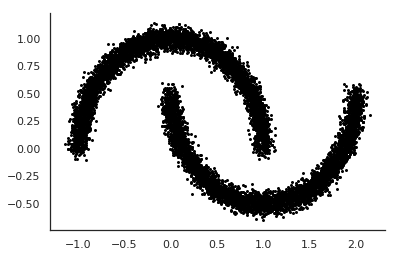

In [117]:
ax = sns.scatterplot(X[:, 0], X[:, 1], color="black", marker='.', linewidth=0);
sns.despine();

In [93]:
X.shape

(10000, 2)

In [129]:
hidden_dim = [512, 512]  
layers = 4
bijectors = []
for i in range(0, layers):
    made = make_network(2, hidden_dim, 2)
    bijectors.append(MAF(made))
    bijectors.append(tfb.Permute(permutation=[1, 0])) 
    
bijectors = tfb.Chain(bijectors=list(reversed(bijectors[:-1])))

In [130]:
distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=bijectors,
    event_shape=[2])

In [131]:
distribution.sample(1000)

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[-0.24651396, -0.4608319 ],
       [ 0.05349635, -0.19349886],
       [-0.72591877,  0.36458433],
       ...,
       [-1.8485498 ,  0.57713276],
       [-0.34956267, -0.07755528],
       [-0.7764887 , -1.2534251 ]], dtype=float32)>

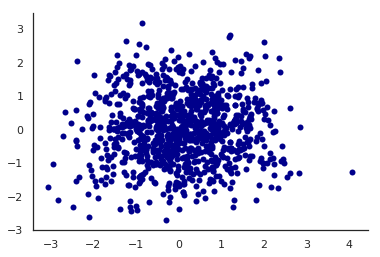

In [132]:
samples = distribution.sample(1000)
#samples = StandardScaler().fit_transform(samples)
sns.scatterplot(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0);
sns.despine();

In [133]:
x_ = tfkl.Input(shape=(2,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(), loss=lambda _, log_prob: -log_prob)

In [137]:
_ = model.fit(x=X,
              y=np.zeros((X.shape[0], 0), dtype=np.float32),
              batch_size= X.shape[0],
              epochs=100,
              steps_per_epoch=1,
              verbose=1,
              shuffle=False)

Train on 10000 samples
Epoch 1/100
10000/10000 [==============================] - 0s 47us/sample - loss: nan
Epoch 2/100
10000/10000 [==============================] - 0s 46us/sample - loss: nan
Epoch 3/100
10000/10000 [==============================] - 0s 44us/sample - loss: nan
Epoch 4/100
10000/10000 [==============================] - 0s 45us/sample - loss: nan
Epoch 5/100
10000/10000 [==============================] - 0s 48us/sample - loss: nan
Epoch 6/100
10000/10000 [==============================] - 0s 44us/sample - loss: nan
Epoch 7/100
10000/10000 [==============================] - 0s 47us/sample


KeyboardInterrupt: 

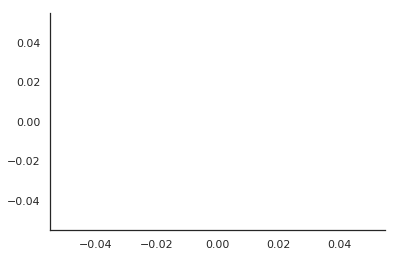

In [138]:
samples = distribution.sample(1000)
#samples = StandardScaler().fit_transform(samples)
sns.scatterplot(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0);
sns.despine();

## Test from latent space of VAE

From notebook of ``Deblender_VAE`` directory.

In [20]:
import sys
sys.path.insert(0,'Deblender_VAE/scripts/tools_for_VAE/')
import tools_for_VAE
from tools_for_VAE import plot, utils
from tools_for_VAE.utils import load_vae_conv

In [21]:
data_dir = "/sps/lsst/users/barcelin/data/isolated_galaxies/27.5/centered/test/"
root = 'galaxies_isolated_20191024'

images = np.load(data_dir+'galaxies_isolated_20191024_0_images.npy', mmap_mode = 'c')
test_sample = [data_dir+'galaxies_isolated_20191024_0_images.npy']

bands_lsst=[4,5,6,7,8,9]

In [25]:
vae_lsst_conv,vae_lsst_utils, encoder_LSST, decoder_LSST, Dkl = utils.load_vae_full('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v_2/v1/bis_bis_bis/mse/',6, folder= True)

W1103 15:02:08.132807 139855004546880 util.py:148] Unused attribute in object (root): ['OBJECT_CONFIG_JSON']
W1103 15:02:08.133836 139855004546880 util.py:148] Unused attribute in object (root).layer-0: ['OBJECT_CONFIG_JSON']
W1103 15:02:08.134526 139855004546880 util.py:148] Unused attribute in object (root).layer_with_weights-0: ['OBJECT_CONFIG_JSON']
W1103 15:02:08.135266 139855004546880 util.py:148] Unused attribute in object (root).layer-2: ['OBJECT_CONFIG_JSON']
W1103 15:02:08.136008 139855004546880 util.py:148] Unused attribute in object (root).layer_with_weights-1: ['OBJECT_CONFIG_JSON']
W1103 15:02:08.136683 139855004546880 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer-0: ['OBJECT_CONFIG_JSON']
W1103 15:02:08.137315 139855004546880 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer-1: ['OBJECT_CONFIG_JSON']
W1103 15:02:08.137980 139855004546880 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer_with_weig

/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v_2/v1/bis_bis_bis/mse/


In [6]:
batch_size = 10000

a = utils.norm(images[:batch_size,1,4:].transpose([0,2,3,1]), bands_lsst, data_dir, channel_last = True)
#output_enc = encoder_LSST.predict(a, batch_size = batch_size)

latent_dim =32
epsilon_std = 1.0

def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon

In [9]:
z = []

for i in range (5):
    print(i)
    output_encoder = encoder_LSST.predict(a, batch_size = batch_size)
    z.append(sampling(output_encoder))

print(np.array(z).shape)
z = np.concatenate(z, axis = 0)
np.save('latent_space_2.npy',z)

0
1
2
3
4
(5, 10000, 32)


/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


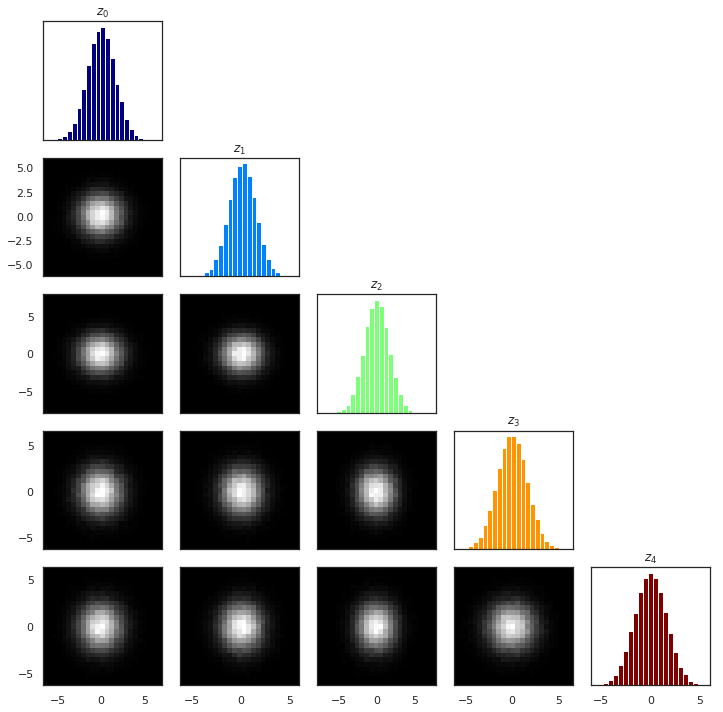

In [8]:
plot.plot_corner_latent(z[:,:5],lim = 6)

In [17]:
z = np.load('latent_space.npy',mmap_mode = 'c')
z_2 = np.load('latent_space_2.npy',mmap_mode = 'c')

z = np.concatenate((z,z_2), axis = 0)

In [18]:
z.shape

(100000, 32)

In [19]:
from scipy.stats import norm
import matplotlib.mlab as mlab


/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


mu: -0.0029954666276466417 sigma: 1.606304417544382
mu: 0.14648211557320126 sigma: 1.385527738249563
mu: -0.002404891142242835 sigma: 1.63748863033781


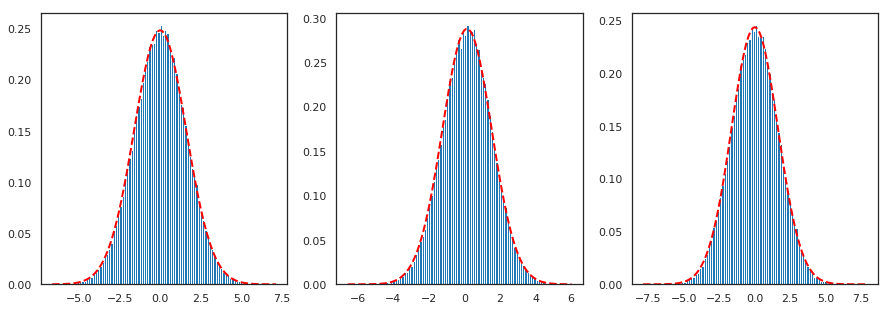

In [45]:
fig, axes = plt.subplots(1,3, figsize = (15,5))

for i in range (3):
    (mu, sigma) = norm.fit(z[:,i])
    n, bins, patches = axes[i].hist(z[:,i], normed = True, bins = 100)
    z_plt = mlab.normpdf( bins, mu, sigma)

    axes[i].plot(bins, z_plt, 'r--', linewidth=2)
    print('mu: '+str(mu)+' sigma: '+str(sigma))

In [46]:
z.shape

(100000, 32)

## First two dimensions of latent space

In [20]:
z_test = StandardScaler().fit_transform(z[:1000,:2])#

/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


mu: -1.1155520951433573e-17 sigma: 0.9999999999999989
mu: 1.7124079931818414e-16 sigma: 1.0000000000000009


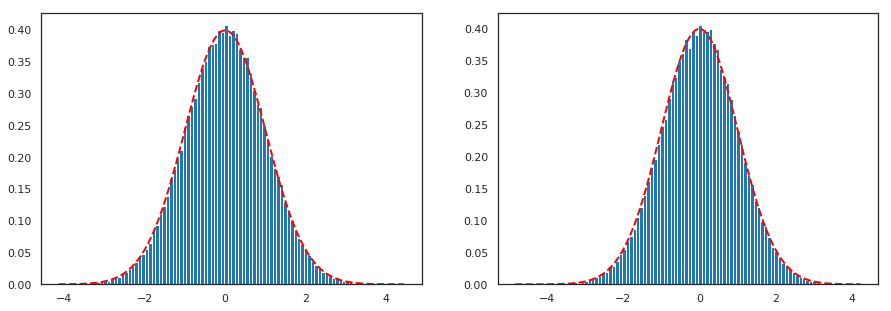

In [48]:
fig, axes = plt.subplots(1,2, figsize = (15,5))

for i in range (2):
    (mu, sigma) = norm.fit(z_test[:,i])
    n, bins, patches = axes[i].hist(z_test[:,i], normed = True, bins = 100)
    z_plt = mlab.normpdf( bins, mu, sigma)

    axes[i].plot(bins, z_plt, 'r--', linewidth=2)
    print('mu: '+str(mu)+' sigma: '+str(sigma))

In [21]:
hidden_dim = [512,512]  
layers =3
bijectors = []
for i in range(0, layers):
    made = make_network(2, hidden_dim, 2)
    bijectors.append(MAF(made))
    bijectors.append(tfb.Permute(permutation=[1, 0])) 
    
bijectors = tfb.Chain(bijectors=list(reversed(bijectors[:-1])))

In [22]:
distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=bijectors,
    event_shape=[2]
)

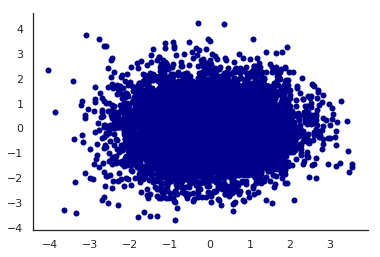

In [23]:
samples = distribution.sample(10000)
samples = StandardScaler().fit_transform(samples)
sns.scatterplot(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0);
sns.despine();

In [24]:
x_ = tfkl.Input(shape=(2,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(), loss=lambda _, log_prob: -log_prob)

In [27]:
_ = model.fit(x=z_test,
              y=np.zeros((z_test.shape[0], 0), dtype=np.float32),
              batch_size= z_test.shape[0],
              epochs=1000,
              steps_per_epoch=1,
              verbose=1,
              shuffle=False)

Train on 1000 samples
Epoch 1/1000
1000/1000 [==============================] - 0s 59us/sample - loss: 2.7763
Epoch 2/1000
1000/1000 [==============================] - 0s 43us/sample - loss: 2.7818
Epoch 3/1000
1000/1000 [==============================] - 0s 40us/sample - loss: 2.7835
Epoch 4/1000
1000/1000 [==============================] - 0s 40us/sample - loss: 2.7808
Epoch 5/1000
1000/1000 [==============================] - 0s 39us/sample - loss: 2.7791
Epoch 6/1000
1000/1000 [==============================] - 0s 38us/sample - loss: 2.7813
Epoch 7/1000
1000/1000 [==============================] - 0s 38us/sample - loss: 2.7840
Epoch 8/1000
1000/1000 [==============================] - 0s 40us/sample - loss: 2.7785
Epoch 9/1000
1000/1000 [==============================] - 0s 39us/sample - loss: 2.7795
Epoch 10/1000
1000/1000 [==============================] - 0s 38us/sample - loss: 2.7795
Epoch 11/1000
1000/1000 [==============================] - 0s 37us/sample - loss: 2.7761
Epoch 12

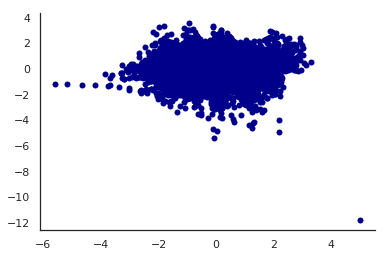

In [28]:
samples = distribution.sample(10000)
samples = StandardScaler().fit_transform(samples)
sns.scatterplot(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0);
sns.despine();

In [53]:
z_test.shape

(100000, 2)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


mu: 1.0082601420435821e-16 sigma: 1.0000000000000018
mu: 7.105427357601002e-20 sigma: 0.9999999999999993


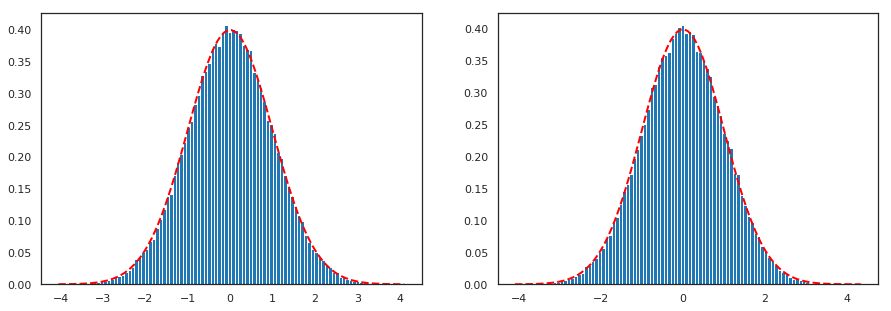

In [55]:
z_test = StandardScaler().fit_transform(z[:,4:6])

fig, axes = plt.subplots(1,2, figsize = (15,5))

for i in range (2):
    (mu, sigma) = norm.fit(z_test[:,i])
    n, bins, patches = axes[i].hist(z_test[:,i], normed = True, bins = 100)
    z_plt = mlab.normpdf( bins, mu, sigma)

    axes[i].plot(bins, z_plt, 'r--', linewidth=2)
    print('mu: '+str(mu)+' sigma: '+str(sigma))

In [28]:
model(z[:,:2])

ValueError: in converted code:

    /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py:2545 _defun_call  *
        return self._make_op(inputs)
    /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py:2523 _make_op
        c_op = ops._create_c_op(graph, node_def, inputs, control_inputs=[])
    /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1622 _create_c_op
        raise ValueError(str(e))

    ValueError: 2 errors while building NodeDef 'sub' using Op<name=Sub; signature=x:T, y:T -> z:T; attr=T:type,allowed=[DT_BFLOAT16, DT_HALF, DT_FLOAT, DT_DOUBLE, DT_UINT8, DT_INT8, DT_UINT16, DT_INT16, DT_INT32, DT_INT64, DT_COMPLEX64, DT_COMPLEX128]>:
    Inconsistent values for attr 'T' DT_DOUBLE vs. DT_FLOAT
    Inconsistent values for attr 'T' DT_DOUBLE vs. DT_FLOAT


## Using only sklearn

In [55]:
z = np.load('latent_space.npy',mmap_mode = 'c')
z_2 = np.load('latent_space_2.npy',mmap_mode = 'c')

z = np.concatenate((z,z_2), axis = 0)

In [56]:
from scipy.stats import norm
import matplotlib.mlab as mlab

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if __name__ == '__main__':


mu: -1.1155520951433573e-17 sigma: 0.9999999999999989
mu: -1.1155520951433573e-17 sigma: 0.9999999999999989
mu: -1.1155520951433573e-17 sigma: 0.9999999999999989
mu: -1.1155520951433573e-17 sigma: 0.9999999999999989
mu: 1.7124079931818414e-16 sigma: 1.0000000000000009
mu: 1.7124079931818414e-16 sigma: 1.0000000000000009
mu: 1.7124079931818414e-16 sigma: 1.0000000000000009
mu: 1.7124079931818414e-16 sigma: 1.0000000000000009
mu: 8.01492205937393e-17 sigma: 0.9999999999999951
mu: 8.01492205937393e-17 sigma: 0.9999999999999951
mu: 8.01492205937393e-17 sigma: 0.9999999999999951
mu: 8.01492205937393e-17 sigma: 0.9999999999999951
mu: -7.105427357601002e-20 sigma: 0.9999999999999953
mu: -7.105427357601002e-20 sigma: 0.9999999999999953
mu: -7.105427357601002e-20 sigma: 0.9999999999999953
mu: -7.105427357601002e-20 sigma: 0.9999999999999953
mu: 1.0082601420435821e-16 sigma: 1.0000000000000018
mu: 1.0082601420435821e-16 sigma: 1.0000000000000018
mu: 1.0082601420435821e-16 sigma: 1.00000000000000

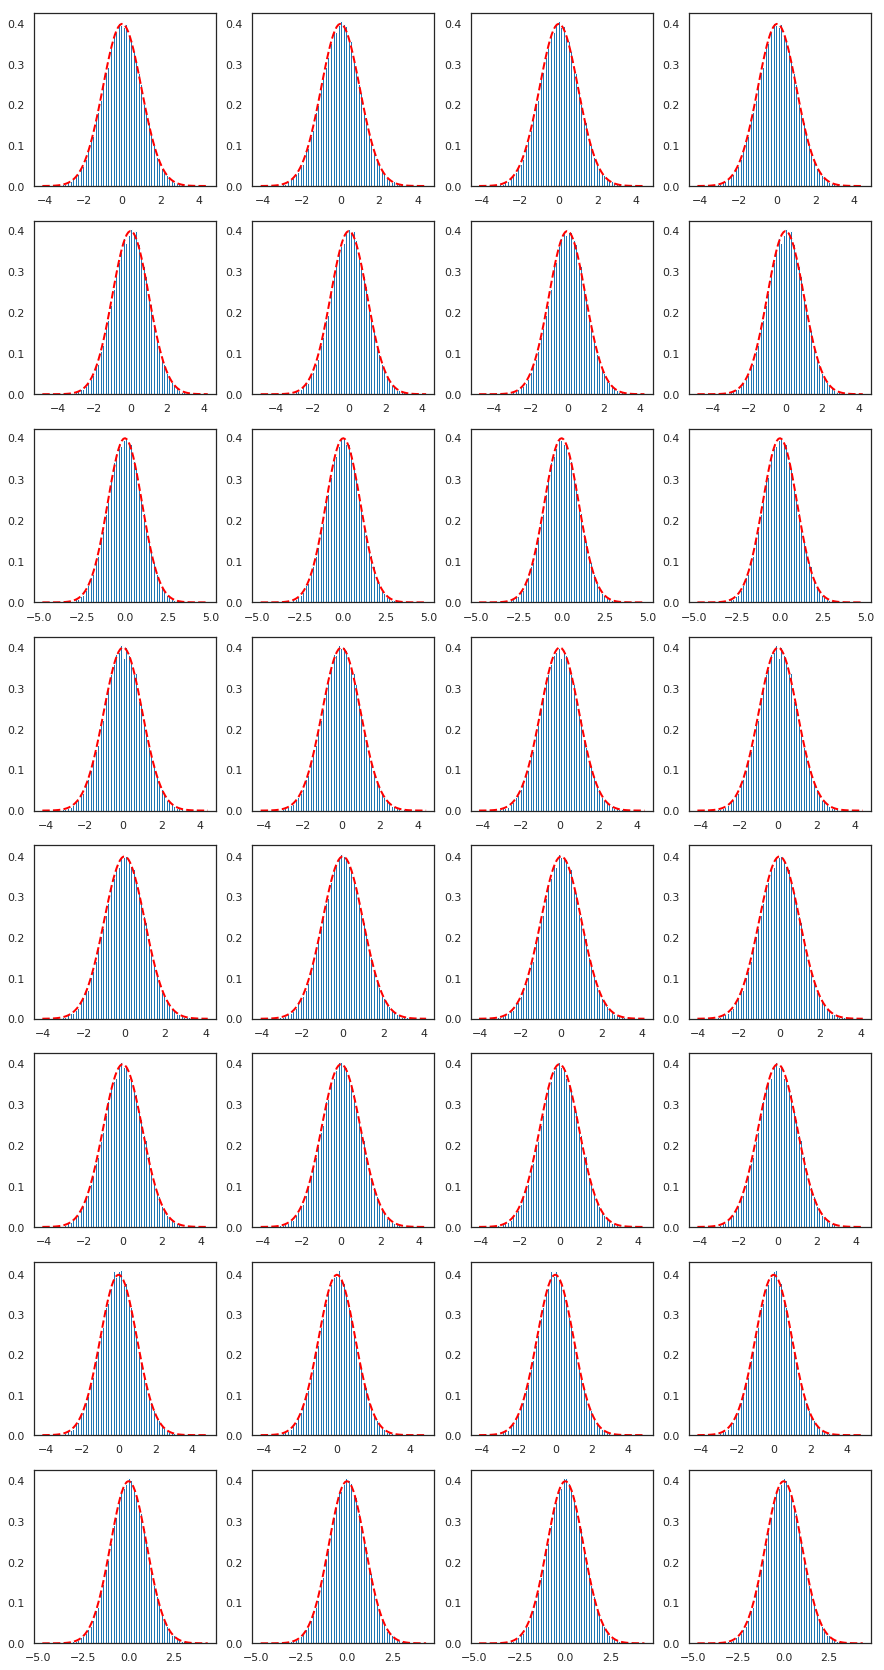

In [57]:
scaler = StandardScaler().fit(z[:,:])
z_test = scaler.transform(z[:,:])
fig, axes = plt.subplots(8,4, figsize = (15,30))

for i in range (8):
    for j in range (4):
        (mu, sigma) = norm.fit(z_test[:,i])
        n, bins, patches = axes[i,j].hist(z_test[:,i], normed = True, bins = 100)
        z_plt = mlab.normpdf( bins, mu, sigma)

        axes[i,j].plot(bins, z_plt, 'r--', linewidth=2)
        print('mu: '+str(mu)+' sigma: '+str(sigma))

/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if __name__ == '__main__':


mu: -0.0029954666276466413 sigma: 1.606304417544382
mu: -0.0029954666276466413 sigma: 1.606304417544382
mu: -0.0029954666276466413 sigma: 1.606304417544382
mu: -0.0029954666276466413 sigma: 1.606304417544382
mu: 0.14648211557320126 sigma: 1.385527738249563
mu: 0.14648211557320126 sigma: 1.385527738249563
mu: 0.14648211557320126 sigma: 1.385527738249563
mu: 0.14648211557320126 sigma: 1.385527738249563
mu: -0.002404891142242832 sigma: 1.63748863033781
mu: -0.002404891142242832 sigma: 1.63748863033781
mu: -0.002404891142242832 sigma: 1.63748863033781
mu: -0.002404891142242832 sigma: 1.63748863033781
mu: 0.0017612746283812277 sigma: 1.6409900300761895
mu: 0.0017612746283812277 sigma: 1.6409900300761895
mu: 0.0017612746283812277 sigma: 1.6409900300761895
mu: 0.0017612746283812277 sigma: 1.6409900300761895
mu: -0.01107336978452871 sigma: 1.6214101027101977
mu: -0.01107336978452871 sigma: 1.6214101027101977
mu: -0.01107336978452871 sigma: 1.6214101027101977
mu: -0.01107336978452871 sigma: 1.6

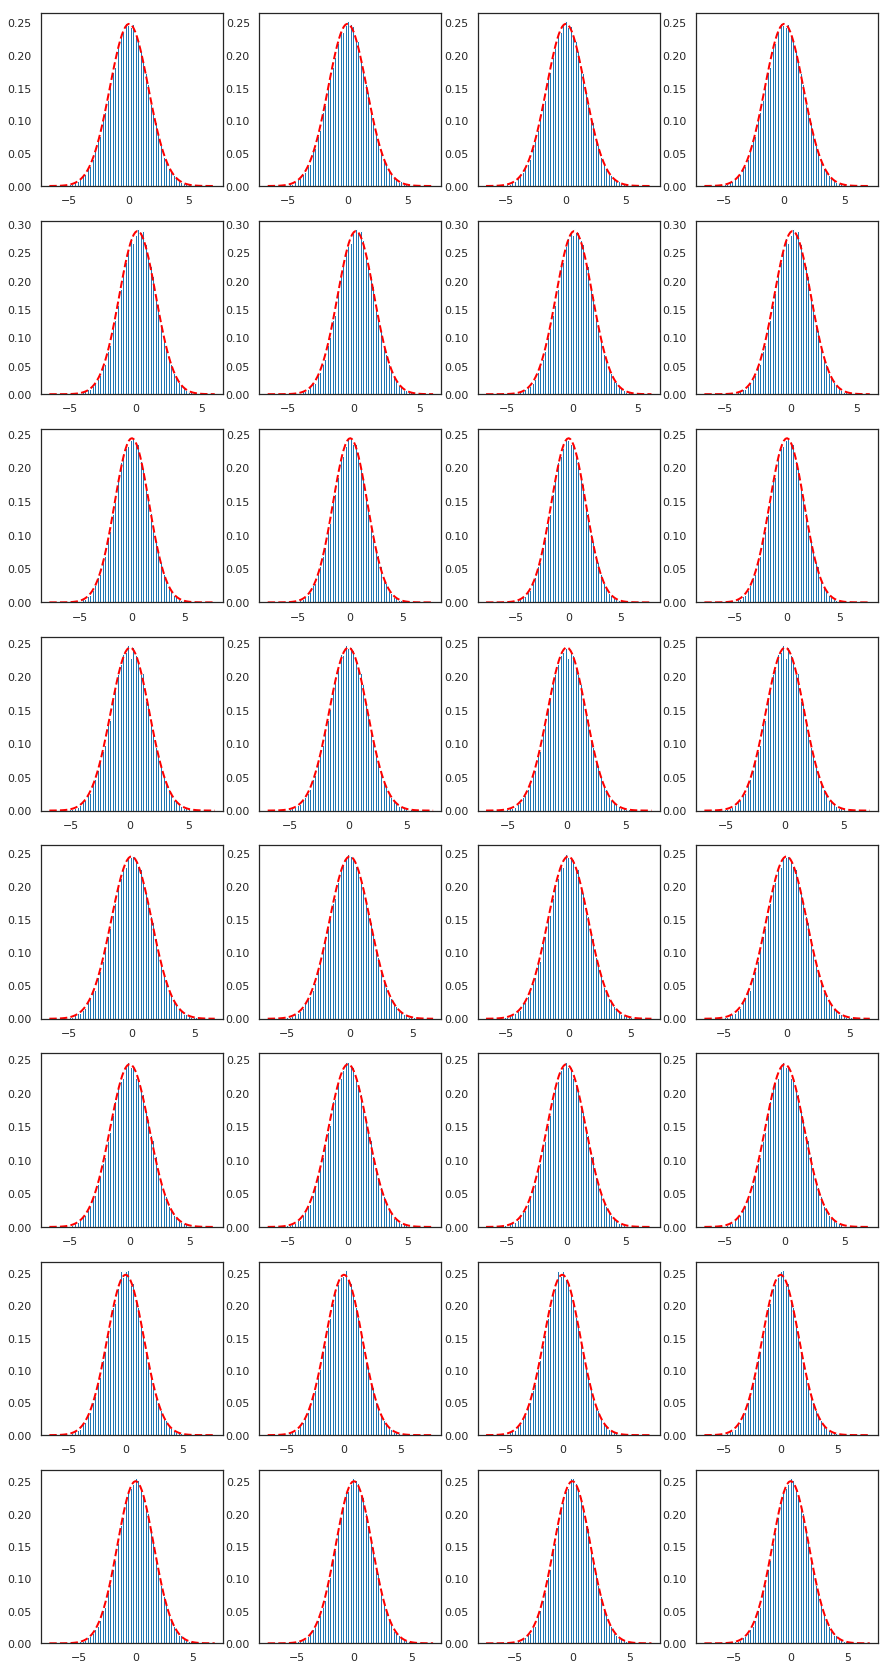

In [58]:
z_test = scaler.inverse_transform(z_test)

fig, axes = plt.subplots(8,4, figsize = (15,30))

for i in range (8):
    for j in range (4):
        (mu, sigma) = norm.fit(z_test[:,i])
        n, bins, patches = axes[i,j].hist(z_test[:,i], normed = True, bins = 100)
        z_plt = mlab.normpdf( bins, mu, sigma)

        axes[i,j].plot(bins, z_plt, 'r--', linewidth=2)
        print('mu: '+str(mu)+' sigma: '+str(sigma))

In [62]:
normal_sample = np.random.normal(loc=0.0, scale=1.0, size=(100,32))

normal_sample_transformed = scaler.inverse_transform(normal_sample)

out = decoder_LSST(normal_sample_transformed)

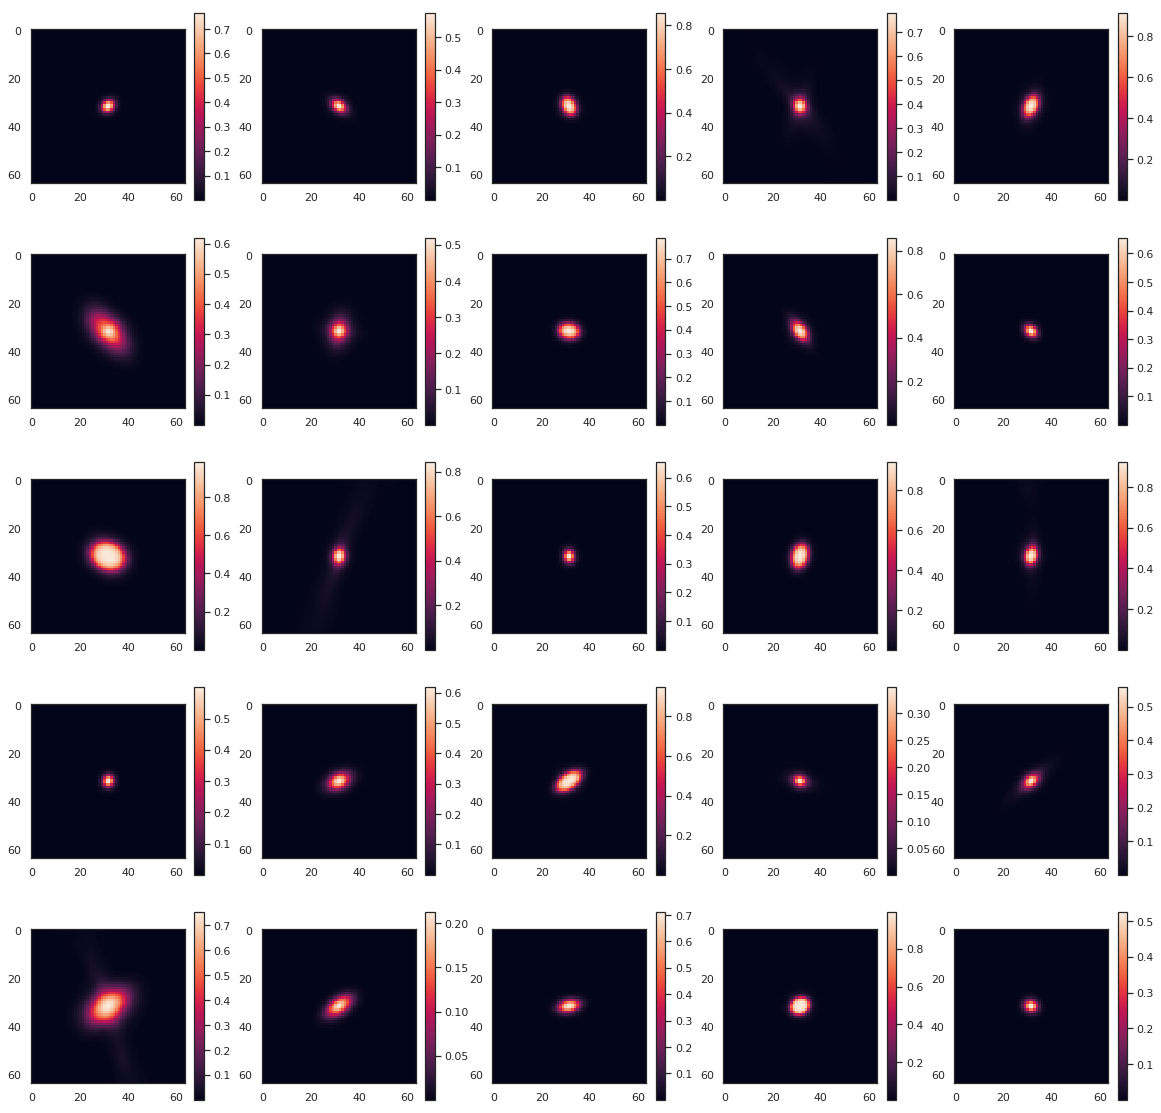

In [63]:
fig, axes = plt.subplots(5,5, figsize = (20,20))
for i in range (5):
    for j in range (5):
        fig_1 = axes[i,j].imshow(out[i*5+j,:,:,2])
        fig.colorbar(fig_1 ,ax=axes[i,j])


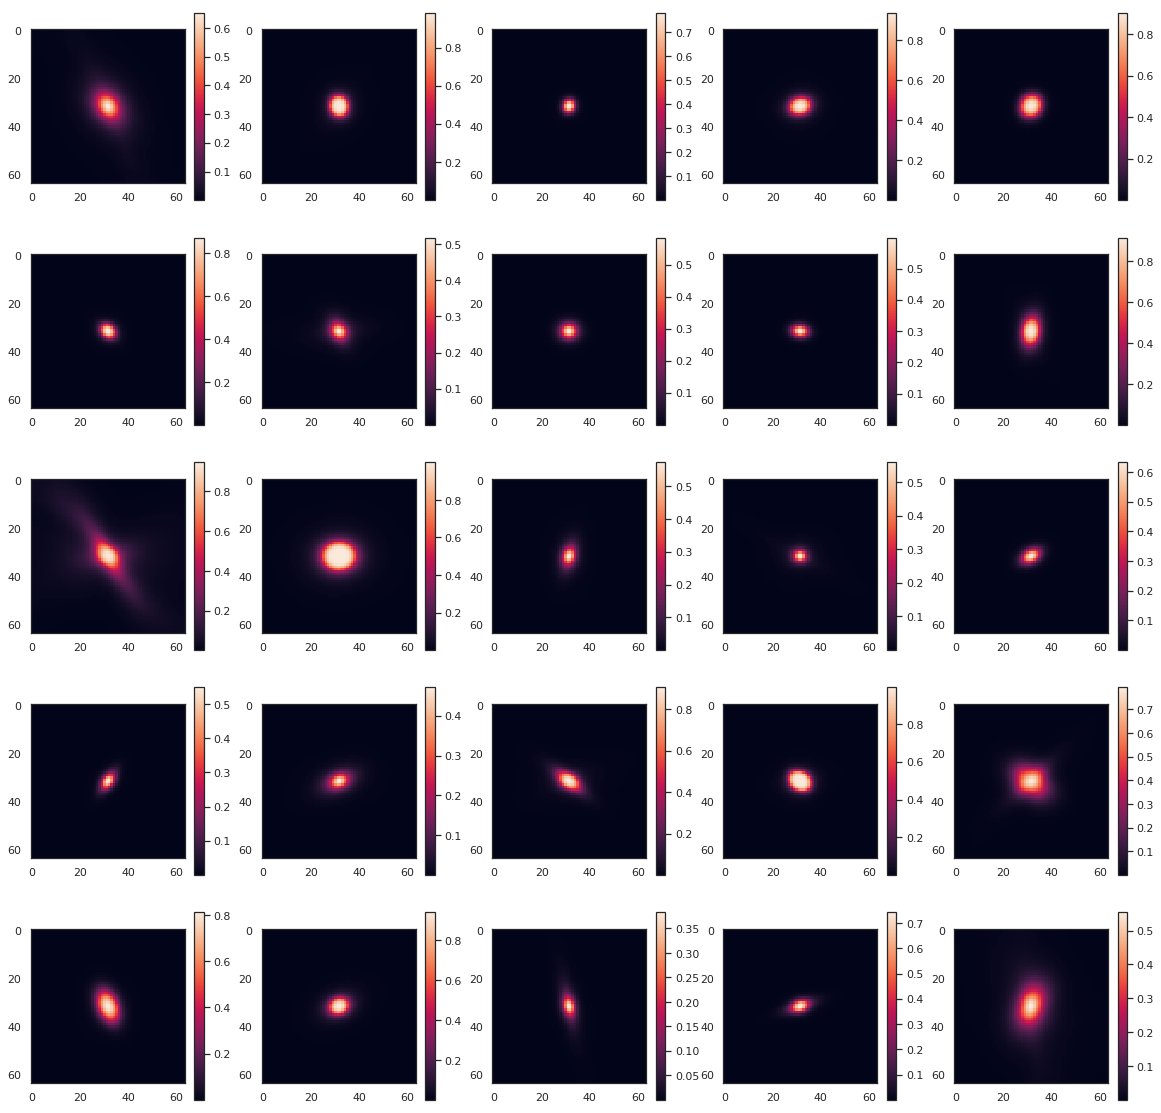

In [64]:
normal_sample = np.random.normal(loc=0.0, scale=1.0, size=(100,32))

out_no_transform = decoder_LSST(normal_sample)

fig, axes = plt.subplots(5,5, figsize = (20,20))
for i in range (5):
    for j in range (5):
        fig_1 = axes[i,j].imshow(out_no_transform[i*5+j,:,:,2])
        fig.colorbar(fig_1 ,ax=axes[i,j])

## All dimensions of latent space

In [15]:
hidden_dim = [512,512,512,512,512,512,512,512,512,512,512,512,512,512,512,512,
             512,512,512,512,512,512,512,512,512,512,512,512,512,512,512,512]  
layers = 2
bijectors = []
for i in range(0, layers):
    made = make_network(32, hidden_dim, 32)
    bijectors.append(MAF(made))
    bijectors.append(tfb.Permute(permutation=[1, 0])) 
    
bijectors = tfb.Chain(bijectors=list(reversed(bijectors[:-1])))

In [16]:
distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=bijectors,
    event_shape=[32]
)

In [17]:
x_ = tfkl.Input(shape=(32,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(), loss=lambda _, log_prob: -log_prob)

ValueError: Dimension must be 2 but is 32 for 'unstack' (op: 'Unpack') with input shapes: [?,32,32].

In [ ]:
_ = model.fit(x=X,
              y=np.zeros((X.shape[0], 0), dtype=np.float32),
              batch_size= X.shape[0],
              epochs=1000,
              steps_per_epoch=1,
              verbose=0,
              shuffle=False)